In [286]:
import random

INITIAL_GROUP = 25
groups = []
for i in range(0,4):
  for _ in range(0,INITIAL_GROUP):
    groups.append({"wealth":0,"group":i,"gamesPlayed":0})

In [287]:
import numpy as np
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
labels = ["Saints", "Buddies", "Fight Club", "Vandals"]
xaxes = [[],[],[],[]]
yaxes = [[],[],[],[]]
INTERVAL = 50

def plotGroups(groups, tick):
  if (tick % INTERVAL == 0): 
    clear_output(wait=True)
    plt.cla()
  for i in range(0,len(xaxes)):
    xaxes[i].append(tick)
    yaxes[i].append(groups[i])
    if (tick % INTERVAL == 0): plt.plot(xaxes[i], yaxes[i])#, label=labels[i])
  if (tick % INTERVAL == 0):
    plt.legend(labels, loc='best', fancybox=True, framealpha=0.5)
    plt.pause(0.05)

def sumGroups(groups, count):
  groupTotals=[0,0,0,0]
  for person in groups:
    if (person["gamesPlayed"] > 0):
      groupTotals[person["group"]] += person["wealth"] / person["gamesPlayed"]
  for i in range(0,4):
    if(groupTotals[i] > 0):
      groupTotals[i] = groupTotals[i] / count[i] 
  return groupTotals

def countGroups(groups):
  groupTotals=[0,0,0,0]
  for person in groups:
    groupTotals[person["group"]] += 1
  return groupTotals

<Figure size 432x288 with 0 Axes>

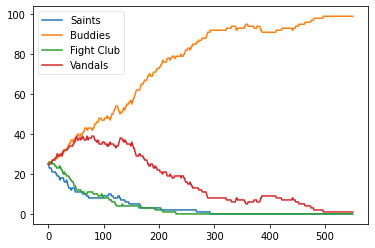

In [288]:

stopCounter = 0
for tick in range(0,1001):
  selection = random.sample(range(0,len(groups)),2)
  groups[selection[0]]["gamesPlayed"] += 1
  groups[selection[1]]["gamesPlayed"] += 1
  groups[selection[0]]["wealth"] += getPayoff(groups[selection[0]]["group"],groups[selection[1]]["group"])
  groups[selection[1]]["wealth"] += getPayoff(groups[selection[1]]["group"],groups[selection[0]]["group"])
  if (groups[selection[0]]["wealth"] > groups[selection[1]]["wealth"]):
    groups[selection[1]]["group"] = groups[selection[0]]["group"]
  elif (groups[selection[1]]["wealth"] > groups[selection[0]]["wealth"]):
    groups[selection[0]]["group"] = groups[selection[1]]["group"]
  
  groupCounts = countGroups(groups)
  groupWealths = sumGroups(groups, groupCounts)
  plotGroups(groupCounts,tick)
  if (groupCounts.count(0) == 3):
    stopCounter+=1
  if (stopCounter > 10):
    break

In [289]:
import numpy as np

class NeuralNetwork(object):
  def __init__(self, numInput, numHidden, numOutput):
    self.fitness = 0
    self.numInput = numInput + 1 # Add bias node to inputs
    self.numHidden = numHidden
    self.numOutput = numOutput

    self.wh = np.random.randn(self.numHidden, self.numInput) 
    self.wo = np.random.randn(self.numOutput, self.numHidden)

    self.ReLU = lambda x : max(0,x)

  def softmax(self, x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

  def feedForward(self, inputs):
    inputsBias = inputs[:]
    inputsBias.insert(len(inputs), 1)

    h1 = np.dot(self.wh, inputsBias)
    h1 = [self.ReLU(x) for x in h1]

    output = np.dot(self.wo, h1)
    return self.softmax(output)

  def getWeightsLinear(self):
    flat_wh = list(self.wh.flatten())
    flat_wo = list(self.wo.flatten())
    return( flat_wh + flat_wo )

  def setWeightsLinear(self, Wgenome):
    numWeights_IH = self.numHidden * (self.numInput)
    self.wh = np.array(Wgenome[:numWeights_IH])
    self.wh = self.wh.reshape((self.numHidden, self.numInput))
    self.wo = np.array(Wgenome[numWeights_IH:])
    self.wo = self.wo.reshape((self.numOutput, self.numHidden))

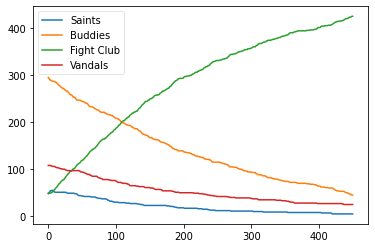

In [312]:
from deap import base
from deap import creator
from deap import tools
from datetime import datetime
import random
import numpy as np

numInputNodes = 7
numHiddenNodes = 8
numOutputNodes = 4

IND_SIZE = ((numInputNodes+1) * numHiddenNodes) +  + (numHiddenNodes * numOutputNodes)

class player():
  def __init__(self, IND_SIZE):
    self.wealth = 0
    self.startingGroup = random.randint(0,3)
    self.group = self.startingGroup
    self.gameCount = 0
    self.weights = tools.initRepeat(list, toolbox.attr_float, IND_SIZE)
    #self.fitness = creator.FitnessMax
    self.fitness = 0.0
  
  def evaluate(self,opponent,network, numGames):
    output = network.feedForward([self.wealth, self.gameCount, self.group, opponent.wealth, opponent.gameCount, opponent.group, numGames])
    decision = np.argmax(output, axis=0)
    if (self.group != decision):
      self.group = decision
    self.fitness = self.wealth

  def addPayoff(self, opponent):
    payoffs = [[4,0,4,0],[6,4,6,1],[4,0,1,0],[6,1,6,0]]
    self.wealth += payoffs[self.group][opponent.group]
    self.gameCount += 1

toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", player, IND_SIZE)

toolbox.register("mate", tools.cxOnePoint)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def sumGroups(groups):
  groupTotals=[0,0,0,0]
  for person in groups:
    groupTotals[person.group] += person.wealth
  return groupTotals

def avgGroups(groups, count):
  groupTotals=[0,0,0,0]
  for person in groups:
    if (person.gameCount > 0):
      groupTotals[person.group] += person.wealth / person.gameCount
  for i in range(0,4):
    if(groupTotals[i] > 0):
      groupTotals[i] = groupTotals[i] / count[i] 
  return groupTotals

def countGroups(pop):
  groupTotals=[0,0,0,0]
  for person in pop:
    groupTotals[person.group] += 1
  return groupTotals

NGEN = 100
NGAMES = 500
CXPB = 0.2
MUTPB = 0.2
POP = 500

network = NeuralNetwork(numInputNodes, numHiddenNodes, numOutputNodes)

pop = toolbox.population(n=POP)

for g in range(NGEN):
  print("-- Generation %i --" % g)
  bestfit = 0
  for person in pop:
    if(bestfit < person.fitness):
      bestfit = person.fitness
  offspring = toolbox.select(pop, len(pop))
  offspring = list(map(toolbox.clone, offspring))
  for person in offspring:
    person.wealth = 0
    person.gameCount = 0
    person.group = person.startingGroup
    person.fitness = 0.0
  for child1, child2 in zip(offspring[::2], offspring[1::2]):
    if random.random() < CXPB:
      toolbox.mate(child1.weights, child2.weights)

  for mutant in offspring:
    if random.random() < MUTPB:
      toolbox.mutate(mutant.weights)
      #mutant.startingGroup = random.randint(0,3)

  for r in range(NGAMES):
    selection = random.sample(range(POP),2)
    offspring[selection[0]].addPayoff(offspring[selection[1]])
    offspring[selection[1]].addPayoff(offspring[selection[0]])
    offspring[selection[0]].evaluate(offspring[selection[1]],network,r)
    offspring[selection[1]].evaluate(offspring[selection[0]],network,r)
  
  pop[:] = offspring
  print("Group avg    : " + str(avgGroups(pop,countGroups(pop))))
  print("Group count  : "+str(countGroups(pop)))


import numpy as np
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
labels = ["Saints", "Buddies", "Fight Club", "Vandals"]
xaxes = [[],[],[],[]]
yaxes = [[],[],[],[]]
INTERVAL = 50

def plotGroups(groups, tick):
  if (tick % INTERVAL == 0): 
    clear_output(wait=True)
    plt.cla()
  for i in range(0,len(xaxes)):
    xaxes[i].append(tick)
    yaxes[i].append(groups[i])
    if (tick % INTERVAL == 0): plt.plot(xaxes[i], yaxes[i])#, label=labels[i])
  if (tick % INTERVAL == 0):
    plt.legend(labels, loc='best', fancybox=True, framealpha=0.5)
    plt.pause(0.05)

for person in pop:
  person.wealth = 0
  person.gameCount = 0
  person.group = person.startingGroup
  person.fitness = 0.0

for r in range(500):
  selection = random.sample(range(POP),2)
  pop[selection[0]].addPayoff(pop[selection[1]])
  pop[selection[1]].addPayoff(pop[selection[0]])
  pop[selection[0]].evaluate(pop[selection[1]],network,r)
  pop[selection[1]].evaluate(pop[selection[0]],network,r)
  groupCounts = countGroups(pop)
  plotGroups(groupCounts,r)